In [1]:
import os
import numpy as np
import cv2
import copy
import time
from PIL import Image

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
from torch.nn import functional as F
import matplotlib.pyplot as plt

D:\Users\APawar\Anaconda3\envs\rock-paper-scissors\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Loading the Dataset
#### Set the location where your dataset is present. It is important that the dataset is segregated in the form of:
dataset/train/rock/xx.jpg \
dataset/train/rock/yy.jpg \
... \
dataset/test/rock/xx.jpg \
dataset/test/rock/yy.jpg 

In [3]:
data_dir = "./dataset/"

### Data Augmentation to improve training

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # based on imagenet
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # based on imagenet
    ]),
}

### DataLoaders

In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize the dataset before training

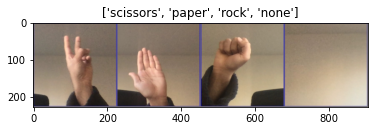

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training model 

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualize the results of the model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Using a Pretrained Model

Using ResNet50 as a backbone and freezing the layers so as to prevent backpropagation. Adding 2 fully connected layers to the backbone for classification

In [9]:
model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 128),
                            nn.ReLU(),
                            nn.Linear(128, 4))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.9626 Acc: 0.6376
test Loss: 0.6268 Acc: 0.7255

Epoch 1/9
----------
train Loss: 0.4804 Acc: 0.8373
test Loss: 0.2949 Acc: 0.9069

Epoch 2/9
----------
train Loss: 0.3335 Acc: 0.8765
test Loss: 0.6243 Acc: 0.7255

Epoch 3/9
----------
train Loss: 0.3563 Acc: 0.8604
test Loss: 0.1556 Acc: 0.9755

Epoch 4/9
----------
train Loss: 0.3534 Acc: 0.8594
test Loss: 0.0671 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.2570 Acc: 0.9026
test Loss: 0.1400 Acc: 0.9608

Epoch 6/9
----------
train Loss: 0.2250 Acc: 0.9127
test Loss: 0.5697 Acc: 0.7255

Epoch 7/9
----------
train Loss: 0.1643 Acc: 0.9418
test Loss: 0.0734 Acc: 0.9951

Epoch 8/9
----------
train Loss: 0.1595 Acc: 0.9518
test Loss: 0.0600 Acc: 0.9951

Epoch 9/9
----------
train Loss: 0.1401 Acc: 0.9568
test Loss: 0.1557 Acc: 0.9510

Training complete in 3m 16s
Best test Acc: 1.000000


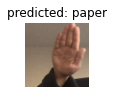

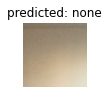

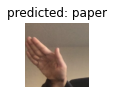

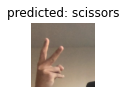

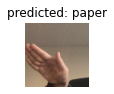

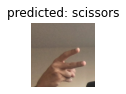

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Saving the model \
Save the model to a path so as to do a real-time inference in the game


In [ ]:
torch.save(model_conv.state_dict(), './resnet50_cv.pt')